<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Transfer_Learning_for_Image_clf(Cats_vs_Dogs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras.models import Model  # for model creation functional API

#Global avg pooling is similar to flatten(), but here if shape is 8 , 8 , 2048 result is 2048 rather than 8 * 8 * 2048
# makes things simpler
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,\
 Dropout 



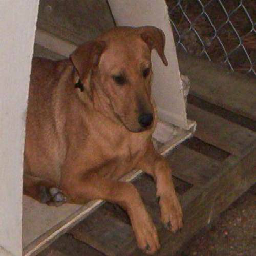

In [4]:
path = "/content/drive/MyDrive/Computer Vision Masterclass Files/Datasets/cat_dog_2.zip"

zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall("./")
zip_object.close()

keras.preprocessing.image.load_img("/content/cat_dog_2/training_set/dog/dog.100.jpg", target_size = (256, 256))

### Train and Test Dataset Split

In [5]:
training_gen = ImageDataGenerator(
    rescale = 1/ 255.,
    horizontal_flip = True,
    zoom_range = 0.2, 
    rotation_range = 15,
    width_shift_range = 0.1
)

train_dataset = training_gen.flow_from_directory(
    "/content/cat_dog_2/training_set",
    target_size = (128, 128),
    batch_size = 128,
    class_mode = "categorical",
    shuffle = True,
)



test_datagen = ImageDataGenerator(rescale = 1/ 255.)

test_dataset= test_datagen.flow_from_directory(
    "/content/cat_dog_2/test_set",
    target_size= (128, 128),
    batch_size = 1,
    class_mode = "categorical",
    shuffle = False
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
print(train_dataset.class_indices)

{'cat': 0, 'dog': 1}


### Transfer Learning(Building and Training Model)

In [7]:
# base_model = keras.applications.ResNet50(weights = "imagenet", include_top = False,
#                                 input_tensor = Input(shape = (128, 128, 3)))  # shape is optional


base_model = keras.applications.MobileNetV2(weights = "imagenet", include_top = False,
                                input_shape = (128, 128, 3))  

base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [8]:
print(len(base_model.layers))

for layer in base_model.layers:
  layer.trainable = False

154


In [9]:
base_model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [10]:
head = base_model.output

head = GlobalAveragePooling2D()(head)
head = Dense(641, "relu")(head)
head = Dropout(0.2)(head)
head = Dense(641, "relu")(head)
head = Dropout(0.2)(head)
head = Dense(2, activation = "softmax")(head)

In [11]:
model = Model(inputs = base_model.inputs, outputs = head)


# model.summary()

len(model.layers)

160

In [12]:
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [13]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 10)

Epoch 1/10
32/32 [==============================] - 39s 1s/step - loss: 0.2662 - accuracy: 0.8978 - val_loss: 0.1038 - val_accuracy: 0.9570
Epoch 2/10
32/32 [==============================] - 39s 1s/step - loss: 0.1095 - accuracy: 0.9550 - val_loss: 0.1113 - val_accuracy: 0.9540
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.1009 - accuracy: 0.9565 - val_loss: 0.1113 - val_accuracy: 0.9570
Epoch 4/10
32/32 [==============================] - 31s 971ms/step - loss: 0.1029 - accuracy: 0.9555 - val_loss: 0.0926 - val_accuracy: 0.9620
Epoch 5/10
32/32 [==============================] - 37s 1s/step - loss: 0.0821 - accuracy: 0.9657 - val_loss: 0.0898 - val_accuracy: 0.9690
Epoch 6/10
32/32 [==============================] - 39s 1s/step - loss: 0.0827 - accuracy: 0.9685 - val_loss: 0.0988 - val_accuracy: 0.9620
Epoch 7/10
32/32 [==============================] - 34s 1s/step - loss: 0.0830 - accuracy: 0.9655 - val_loss: 0.1076 - val_accuracy: 0.9560
Epoch 8/10
32/32 

Model accuracy: 0.958
Model precision: 0.9337121212121212
Model recall: 0.986
Model f1_score: 0.9591439688715954


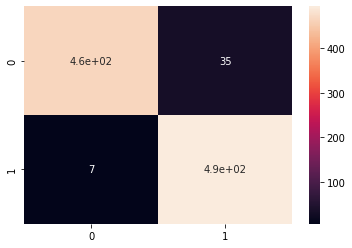

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
confusion_matrix, classification_report


y_test = test_dataset.classes
predictions = np.argmax(model.predict(test_dataset), axis = 1)

print(f"Model accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model precision: {precision_score(y_test, predictions)}")
print(f"Model recall: {recall_score(y_test, predictions)}")
print(f"Model f1_score: {f1_score(y_test, predictions)}")


sns.heatmap(confusion_matrix(y_test, predictions), annot =True)

In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       500
           1       0.93      0.99      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



### Fine Tuning( really no need to see model's accuracy is pretty high)

In [33]:
base_model.trainable = True

fine_tuning_at = 100

for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [34]:
head = base_model.output

head = GlobalAveragePooling2D()(head)
head = Dense(641, "relu")(head)
head = Dropout(0.2)(head)
head = Dense(641, "relu")(head)
head = Dropout(0.2)(head)
head = Dense(2, activation = "softmax")(head)

In [35]:
model = Model(inputs = base_model.inputs, outputs = head)

# reduce learning rate to avoid overfitting
base_learning_rate = 0.0001


model.compile(optimizer= keras.optimizers.Adam(learning_rate = base_learning_rate / 10),
              loss = "categorical_crossentropy", metrics = ["accuracy"])

In [36]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 15)

Epoch 1/15
32/32 [==============================] - 35s 1s/step - loss: 0.3627 - accuracy: 0.9038 - val_loss: 0.8843 - val_accuracy: 0.8400
Epoch 2/15
32/32 [==============================] - 30s 958ms/step - loss: 0.1805 - accuracy: 0.9728 - val_loss: 0.9756 - val_accuracy: 0.8580
Epoch 3/15
32/32 [==============================] - 31s 980ms/step - loss: 0.1241 - accuracy: 0.9835 - val_loss: 0.9368 - val_accuracy: 0.8740
Epoch 4/15
32/32 [==============================] - 32s 1s/step - loss: 0.0927 - accuracy: 0.9835 - val_loss: 0.8800 - val_accuracy: 0.8870
Epoch 5/15
32/32 [==============================] - 31s 958ms/step - loss: 0.0719 - accuracy: 0.9865 - val_loss: 0.8065 - val_accuracy: 0.8980
Epoch 6/15
32/32 [==============================] - 31s 959ms/step - loss: 0.0575 - accuracy: 0.9890 - val_loss: 0.7345 - val_accuracy: 0.9060
Epoch 7/15
32/32 [==============================] - 30s 953ms/step - loss: 0.0494 - accuracy: 0.9883 - val_loss: 0.6703 - val_accuracy: 0.9160
Epoch

Model accuracy: 0.943
Model precision: 0.9079189686924494
Model recall: 0.986
Model f1_score: 0.9453499520613614


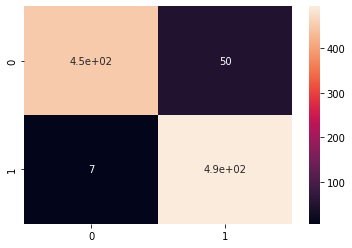

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
confusion_matrix, classification_report


y_test = test_dataset.classes
predictions = np.argmax(model.predict(test_dataset), axis = 1)

print(f"Model accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model precision: {precision_score(y_test, predictions)}")
print(f"Model recall: {recall_score(y_test, predictions)}")
print(f"Model f1_score: {f1_score(y_test, predictions)}")


sns.heatmap(confusion_matrix(y_test, predictions), annot =True)

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       500
           1       0.91      0.99      0.95       500

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.95      0.94      0.94      1000



### Saving and Loading Model

In [39]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)


In [42]:
from keras.models import save_model
model_saved = save_model(model, "/content/weights.hdf5")

In [43]:
# Load the model
with open("model.json", "r") as json_file:
  json_saved_model = json_file.read()

json_saved_model


network_loaded = keras.models.model_from_json(json_saved_model)
network_loaded.load_weights("weights.hdf5")
network_loaded.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

# network.summary()

### Clf a single image

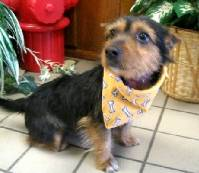

In [49]:
image = cv2.imread("/content/cat_dog_2/test_set/dog/dog.3509.jpg")
cv2_imshow(image)

In [50]:
image = cv2.resize(image, (128, 128))

# scale image
image = image / 255.

image = image.reshape(1, 128, 128, 3)

result = np.argmax(network_loaded.predict(image))

if(result == 0):
  print("Cat")
else:
  print("Dog")

Dog
